In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, datasets
import matplotlib.pyplot as plt

keras.backend.set_image_data_format('channels_last')

In [2]:
(X_train, Y_train), (X_test, Y_test) = datasets.cifar10.load_data()

In [3]:
# Normalize data
X_train = X_train / 255
X_test = X_test / 255

In [4]:
# Shapes for training and test data
print(f'Training: X {X_train.shape}, Y {Y_train.shape}')
print(f'Test: X {X_test.shape}, Y {Y_test.shape}')

Training: X (50000, 32, 32, 3), Y (50000, 1)
Test: X (10000, 32, 32, 3), Y (10000, 1)


In [5]:
def visualize_data(X, Y, imgs):
    s = int(np.sqrt(imgs))
    fig, ax = plt.subplots(s, s, sharex=True, sharey=True, figsize=(10, 10))
    ax = ax.flatten()
    
    for i in range(imgs):
        img = X[i].reshape(32, 32, 3)
        ax[i].imshow(img, interpolation='nearest')
        ax[i].set_title(f'{Y[i]}')
    

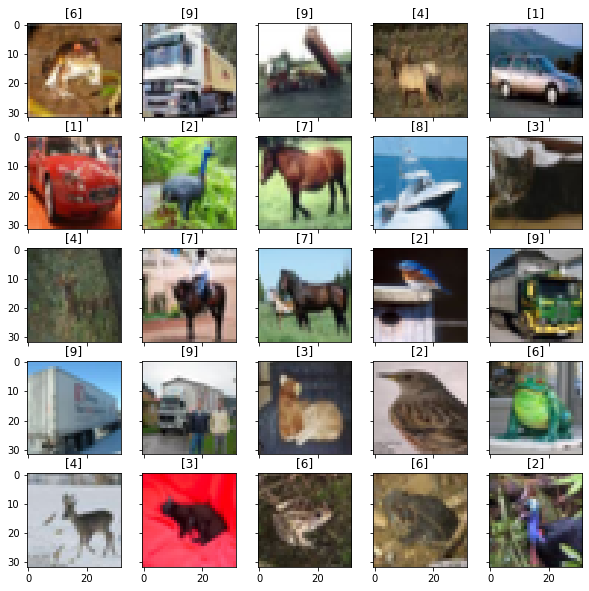

In [6]:
visualize_data(X_train, Y_train, 25)

In [7]:
def identity_block(X, f, filters, stage, block):
    """
    Defines a single block that has both input and output connected by a skip connection.
    Input and Output are of the same size and therefore only adds the input to the output
    """
    
    # Define name basis
    conv_name_base = 'conv2d' + str(stage) + block + "_branch"
    bn_name_base = "bn" + str(stage) + block + "_branch"
    
    # Get filter sizes
    f1, f2, f3 = filters
    
    # Save input value for skip connection
    X_shortcut = X
    
    # Define 3 layers of convolutional blocks
    # First Layer
    X = layers.Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer='glorot_uniform')(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = layers.Activation('relu')(X)
    
    # Second Layer
    X = layers.Conv2D(f2, (f, f), (1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer='glorot_uniform')(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = layers.Activation('relu')(X)
    
    # Third Layer
    X = layers.Conv2D(f3, (1, 1), (1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer='glorot_uniform')(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    
    # Add input to output before activation
    X = layers.Add()([X_shortcut, X])
    X = layers.Activation('relu')(X)

    return X

In [8]:
def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Defines a single block that has input and output connected by a skip conection.
    Input and Output are of different dimensions and therefore need the same stride when executing.
    """
    
    # Define name basis
    conv_name_base = 'conv2d' + str(stage) + block + "_branch"
    bn_name_base = "bn" + str(stage) + block + "_branch"
    
    # Get filter sizes
    f1, f2, f3 = filters
    
    # Save input value for skip connection
    X_shortcut = X
    
    # Define 3 layers of convolutional blocks
    # First Layer reduces size
    X = layers.Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer='glorot_uniform')(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = layers.Activation('relu')(X)
    
    # Second layer keeps same size
    X = layers.Conv2D(f2, (f, f), (1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer='glorot_uniform')(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = layers.Activation('relu')(X)
    
    # Third layer keeps same size with 1x1 convolutions
    X = layers.Conv2D(f3, (1, 1), (1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer='glorot_uniform')(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    
    # Perform Skip Connection (CONV -> BN)
    X_shortcut = layers.Conv2D(f3, (1, 1), (s, s), padding='valid', name=conv_name_base + '1', kernel_initializer='glorot_uniform')(X_shortcut)
    X_shortcut = layers.BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)
    
    # Add both input and outputs and perform activation
    X = layers.Add()([X_shortcut, X])
    X = layers.Activation('relu')(X)
    
    return X

In [9]:
def ResNet50(input_shape, num_classes):
    """
    Define the ResNet50 Architecture using the blocks defined above
    """
    
    # Define an input as a tensor with shape=input_shape
    X_input = keras.Input(input_shape)
    
    # Zero Padding
    X = layers.ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = layers.Conv2D(64, (7 ,7), (2, 2), name='conv1', kernel_initializer='glorot_uniform')(X)
    X = layers.BatchNormalization(axis=3, name='bn_conv1')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Stage 2 (1 conv_block, 2 iden_block)
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3 (1 conv_block, 3 iden_block)
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    
    # Stage 4 (1 conv_block, 5 iden_block)
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    
    # Stage 5 (1 conv_block, 2 iden_block)
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    
    # Average Pooling
    X = layers.GlobalAveragePooling2D()(X)
    
    # Fully connected layers
    X = layers.Flatten()(X)
    X = layers.Dense(num_classes, activation='softmax', name='fc' + str(num_classes), kernel_initializer='glorot_uniform')(X)
    
    # Create model
    model = keras.Model(inputs=X_input, outputs=X, name='ResNet50')
    
    return model

In [10]:
# Convert Y_train and Y_test into categorical (one_hot)
Y_train = keras.utils.to_categorical(Y_train, 10)
Y_test = keras.utils.to_categorical(Y_test, 10)

In [11]:
# Build model
model = ResNet50(X_train.shape[1:], 10)

In [12]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Fit model
history = model.fit(X_train, Y_train, epochs=2, batch_size=32)

Epoch 1/2
1563/1563 [==============================] - 287s 184ms/step - loss: 1.8579 - accuracy: 0.4132
Epoch 2/2
1563/1563 [==============================] - 286s 183ms/step - loss: 2.1503 - accuracy: 0.3033


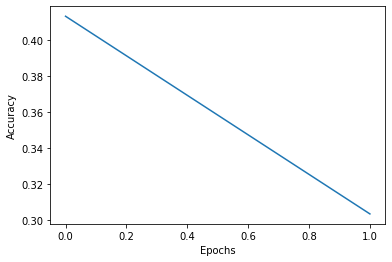

In [15]:
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()